In [1]:
from DLtools.Data_preprocess import series_to_supervised,load_data,preprocess

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()

DataFrame shape: (465169, 35)


In [9]:
X_in = df['2013-01-01':'2015-01-01'].interpolate(limit=7)
X_in = X_in.astype('float32')

In [10]:
LOOKBACK=7

prep = preprocess(X_in,LOOKBACK,1)
train_X, train_Y = prep.train_X,prep.train_Y
val_X,val_y = prep.val_X,prep.val_y
test_X,test_y =prep.test_X,prep.test_Y

ori_trainX,ori_trianY = prep.ori_trainX,prep.ori_trainY

================================================== preview ==================================================
            CHM002_r(t-7)  CHM004_r(t-7)  CHM006_r(t-7)  CPY004_r(t-7)  \
date                                                                     
2013-03-02            0.0            0.0            0.0            0.0   
2013-03-03            0.0            0.0            0.0            0.0   
2013-03-04            0.0            0.0            0.0            0.0   
2013-03-05            0.0            0.0            0.0            0.0   
2013-03-06            0.0            0.0            0.0            0.0   

            CPY009_r(t-7)  CPY010_r(t-7)  CPY015_r(t-7)  KWN002_r(t-7)  \
date                                                                     
2013-03-02            0.0            0.0            0.0            0.0   
2013-03-03            0.0            0.0            0.0            0.0   
2013-03-04            0.0            0.0            0.0            0.0   
2

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(7, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [18]:
EPOCH = 100
BATCH = 7
VALIDATION = (val_X,val_y)

callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=2)
callbacks = [callback_early_stopping]

In [19]:
history = model.fit(train_X, train_Y, epochs=EPOCH, batch_size=BATCH, verbose=1,shuffle=False,validation_data=VALIDATION,callbacks=callbacks)

Epoch 1/100
26/26 [==============================] - 1s 23ms/step - loss: 207.5415 - val_loss: 198.3665
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 190.6668 - val_loss: 158.1315
Epoch 3/100
26/26 [==============================] - 0s 11ms/step - loss: 224.0678 - val_loss: 159.9849
Epoch 4/100
26/26 [==============================] - 0s 12ms/step - loss: 163.6877 - val_loss: 157.2419
Epoch 5/100
26/26 [==============================] - 0s 13ms/step - loss: 149.1713 - val_loss: 130.1346
Epoch 6/100
26/26 [==============================] - 0s 12ms/step - loss: 91.5378 - val_loss: 48.9256
Epoch 7/100
26/26 [==============================] - 0s 13ms/step - loss: 32.8821 - val_loss: 15.1720
Epoch 8/100
26/26 [==============================] - 0s 10ms/step - loss: 5.7390 - val_loss: 2.6076
Epoch 9/100
26/26 [==============================] - 0s 13ms/step - loss: 2.4954 - val_loss: 2.4152
Epoch 10/100
26/26 [==============================] - 0s 10ms/step - loss: 2

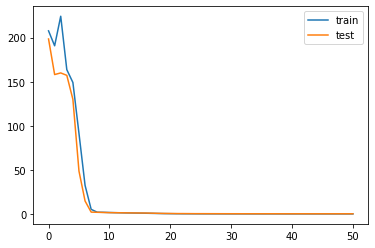

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()